# Sentiment prediction from Amazon reviews
## About DataSet
 This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
## Contents
 - **database.csv :** Contains the table 'Reviews'
 - **Reviews.csv :** Pulled from the corresponding SQLite table named Reviews in database.sqlite
## Data includes:
 - Reviews from Oct 1999 - Oct 2012
 - 568,454 reviews
 - 256,059 users
 - 74,258 products
 - 260 users with > 50 reviews

In [2]:
import sys
import os

# Getting the current script's directory
current_dir = os.getcwd()

# Adding the parent directory to the Python path
sys.path.append(os.path.dirname(current_dir))

In [3]:
#Importing Libraries

import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import pickle
import gensim
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_preprocessing import clean_text, preprocess_text, sentence_to_words
from ml_algorithms.KNN import KNN_train_simple_cv
from ml_algorithms.NaiveBayes import NaiveBayes_train_simple_cv
from ml_algorithms.SGDClassifier import SGDClassifier_train_random_search_cv
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
raw_data = pd.read_csv("C:\Anand\Projects_GWU\Sentiment-prediction-from-Amazon-reviews\data\Reviews.csv")

In [5]:
raw_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [7]:
# Just for faster computation use first 50000 rows 
# ************************************Remove Later********************************************
raw_data = raw_data[:100000]
# ********************************************************************************************

In [8]:
raw_data.shape

(100000, 10)

In [9]:
# Drop rows with rating/score as 3.
value_to_drop = 3

# Drop rows where 'Score' has value 3.
raw_data = raw_data[raw_data['Score'] != value_to_drop]

In [10]:
# After dropping row with score 3
print(raw_data.shape)

#Unique values in Score column must be 1/2/4/5.
print(raw_data.Score.unique())

(91941, 10)
[5 1 4 2]


In [11]:
# Giving 4&5 as Positive and 1&2 as Negative Rating 
def assign_values(value):
    if value < 3:
        return 'Negative'
    else:
        return 'Positive'

raw_data['Review'] = raw_data['Score'].apply(assign_values)

In [12]:
raw_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Review
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [13]:
# Checking for duplicate Reviews 
boolean = not raw_data["Text"].is_unique      
boolean = raw_data['Text'].duplicated().any()
print(boolean)

True


In [14]:
# Drop duplicated Reviews
raw_data = raw_data.drop_duplicates(subset='Text', keep='first')

# Check the shape
print(raw_data.shape)

(81227, 11)


In [15]:
# Check if HelpfulnessNumerator is less than HelpfulnessDenominator, If so then drop those rows
raw_data=raw_data[raw_data.HelpfulnessNumerator<=raw_data.HelpfulnessDenominator]
print(raw_data.shape)

# The observations in the dataset dropped from 568454 to 363834 as there were a lot of Duplicate Reviews and Number of people who found review helpful cannot be greater than number of people who viewed the review. These rows were dropped

# # Check proportions of categories in output label:
# raw_data['Review'].value_counts()

(81225, 11)


In [16]:
# Apply clean_text function to clean the text column.
raw_data['Clean_Text'] = raw_data['Text'].apply(lambda x: clean_text(x))

In [17]:
print(raw_data["Text"].head(10))

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


In [18]:
# Apply text preprocessing to the 'Text' column from data-preprocessing.py file 
raw_data['Clean_Text'] = raw_data['Clean_Text'].apply(preprocess_text)

In [19]:
# Comparing the Original Text and the processed text
print(raw_data["Text"][1])

print("\n After Processing of Text \n")

print(raw_data["Clean_Text"][1])

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

 After Processing of Text 

product arriv label jumbo salt peanutsth peanut actual small size unsalt not sure error vendor intend repres product jumbo


In [20]:
# Converting sentence into words using sentence_to_words function from the data_preprocessing file
list_of_words_in_sentance = sentence_to_words(raw_data, 'Clean_Text')

In [21]:
raw_data["Clean_Text"].iloc[0]

'bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better'

In [22]:
print(raw_data['Clean_Text'])

0        bought sever vital can dog food product found ...
1        product arriv label jumbo salt peanutsth peanu...
2        this confect around centuri light pillowi citr...
3        look secret ingredi robitussin believ found go...
4        great taffi great price there wide assort yumm...
                               ...                        
99995                     love buy anoth box done last one
99996    late father law use rate system meal particula...
99997    this favorit brand korean ramen spici use eat ...
99998    like noodl although say spici somewhat underst...
99999    love noodl twice week the amaz thing feel well...
Name: Clean_Text, Length: 81225, dtype: object


In [23]:
print(f"Sentence cleaned: {raw_data['Clean_Text'].values[0]}")
print(f"Words in cleaned sentence{list_of_words_in_sentance[0]}")

Sentence cleaned: bought sever vital can dog food product found good qualiti the product look like stew process meat smell better labrador finicki appreci product better
Words in cleaned sentence['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'the', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


 Time Based Splitting

In [24]:
final_reviews = raw_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(81225, 12)

In [25]:
# Label Encoding Reviews Column
label_encoder = LabelEncoder()

# Fit and transform the "Review" column
raw_data['Review'] = label_encoder.fit_transform(raw_data['Review'])

 Train and Test Split

In [26]:
# Splitting data into train, Train and Test 
X = raw_data['Clean_Text']
Y = raw_data['Review']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=123)

print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)

X_train, Y_train (64980,) (64980,)
X_test, Y_test (16245,) (16245,)


# Bag of Words

In [27]:
# Bag Of Words
Count_vectorizer = CountVectorizer()
X_train_bow = Count_vectorizer.fit_transform(X_train.values)
print(f"Shape of dataset after converting into BOW is {X_train_bow.get_shape()}")
X_test_bow = Count_vectorizer.transform(X_test.values)  # Use transform instead of fit_transform
print(f"Shape of dataset after converting into BOW is {X_test_bow.get_shape()}")

Shape of dataset after converting into BOW is (64980, 59068)
Shape of dataset after converting into BOW is (16245, 59068)


In [28]:
# Normalize BOW Train and Test Data
X_train_bow=preprocessing.normalize(X_train_bow)
X_test_bow=preprocessing.normalize(X_test_bow)
print("The shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("Test Data Size: ",X_test_bow.shape)

The shape of out text BOW vectorizer  (64980, 59068)
Test Data Size:  (16245, 59068)


# Uni, Bi and Tri Grams

In [29]:
Count_vectorizer_n_grams = CountVectorizer(ngram_range=(1,3) ) 
X_train_n_grams = Count_vectorizer_n_grams.fit_transform(X_train.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_train_n_grams.get_shape())
X_test_n_grams = Count_vectorizer_n_grams.transform(X_test.values)
print("Shape of dataset after converting into uni, bi and tri-grams is ",X_test_n_grams.get_shape())

Shape of dataset after converting into uni, bi and tri-grams is  (64980, 3137279)
Shape of dataset after converting into uni, bi and tri-grams is  (16245, 3137279)


# Tf-Idf Vectorization

In [30]:
# tf-idf Vectorizer
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tf_idf_vectorizer = tf_idf_vectorizer.fit_transform(X_train.values)
X_test_tf_idf_vectorizer = tf_idf_vectorizer.transform(X_test.values)

print("Shape of train dataset after converting into tf-idf is ", X_train_tf_idf_vectorizer.get_shape())
print("Shape of test dataset after converting into tf-idf is ", X_test_tf_idf_vectorizer.get_shape())

Shape of train dataset after converting into tf-idf is  (64980, 1013701)
Shape of test dataset after converting into tf-idf is  (16245, 1013701)


In [31]:
# Normalize Tf-Idf Train and Test Data
X_train_tfidf=preprocessing.normalize(X_train_tf_idf_vectorizer)
X_test_tfidf=preprocessing.normalize(X_test_tf_idf_vectorizer)
print("Train Data Size: ",X_train_tfidf.get_shape())
print("Test Data Size: ",X_test_tfidf.shape)

Train Data Size:  (64980, 1013701)
Test Data Size:  (16245, 1013701)


# word2vec Model
 Making word2vec model using our data set and the same model will be used further.

In [32]:
# Training word2vec model on our own data.
w2v_model=gensim.models.Word2Vec(list_of_words_in_sentance,min_count=5, workers=4) 

In [33]:
# Saving the vocabolary of words in our trained word2vec model
w2v_vocab = list(w2v_model.wv.key_to_index)

In [34]:
# Get the top 10 words most similar words to "quality"
w2v_model.wv.most_similar('good')

[('decent', 0.7190703749656677),
 ('great', 0.6788889169692993),
 ('terrif', 0.6262618899345398),
 ('fantast', 0.6235535144805908),
 ('awesom', 0.6172702312469482),
 ('excel', 0.5739594101905823),
 ('bad', 0.5539141893386841),
 ('amaz', 0.5524314641952515),
 ('tasti', 0.5380934476852417),
 ('yummi', 0.5316511392593384)]

In [35]:
raw_data.shape[0]

81225

# Average word2vec

In [36]:
sent_vectors_avg_word2vec = []; # The avg-w2v for each sentence/review is stored in this list
vector_size = len(w2v_model.wv['good']) 

for sent in tqdm(list_of_words_in_sentance): # Iterating over each review/sentence
    sent_vec = np.zeros(vector_size) 
    cnt_words =0; 
    for word in sent: # Iterating over each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_avg_word2vec.append(sent_vec)
print(len(sent_vectors_avg_word2vec))

100%|██████████| 81225/81225 [01:17<00:00, 1048.32it/s]

81225


In [37]:
X_train_avg_wor2vec, X_test_avg_wor2vec, Y_train_avg_wor2vec, Y_test_avg_wor2vec = train_test_split(sent_vectors_avg_word2vec,Y, test_size=.20, random_state=0)
X_train_avg_wor2vec=preprocessing.normalize(X_train_avg_wor2vec)
X_test_avg_wor2vec=preprocessing.normalize(X_test_avg_wor2vec)
print(X_train_avg_wor2vec.shape)
print(X_test_avg_wor2vec.shape)

(64980, 100)
(16245, 100)


# Tf-Idf Word2vec

In [38]:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(raw_data['Clean_Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_words_in_sentance): # for each review/sentence 
    sent_vec = np.zeros(vector_size) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_vocab:
            vec = w2v_model.wv[word]
            #  tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train_tfidf_word2vec, X_test_tfidf_word2vec, Y_train_tfidf_wor2vec, Y_test_tfidf_wor2vec = train_test_split(tfidf_sent_vectors, Y, test_size=0.20,random_state=0)
X_train_tfidf_word2vec=preprocessing.normalize(X_train_tfidf_word2vec)
X_test_tfidf_word2vec=preprocessing.normalize(X_test_tfidf_word2vec)
print(X_train_tfidf_word2vec.shape)
print(X_test_tfidf_word2vec.shape)

100%|██████████| 81225/81225 [01:32<00:00, 881.25it/s] 


(64980, 100)
(16245, 100)


 KNN on Bag of Words

1 - AUC Score (CV): 0.6285916973795467  Accuracy (CV): 0.8127681402723372
3 - AUC Score (CV): 0.7106322142996386  Accuracy (CV): 0.8433594478642045
5 - AUC Score (CV): 0.7452882826240689  Accuracy (CV): 0.8508673754896474
7 - AUC Score (CV): 0.7675600721083683  Accuracy (CV): 0.8539451594851707
9 - AUC Score (CV): 0.7788300448800298  Accuracy (CV): 0.8545980227569483
11 - AUC Score (CV): 0.7863038545817241  Accuracy (CV): 0.8542249580302183
13 - AUC Score (CV): 0.7920927264793939  Accuracy (CV): 0.8533855623950756
15 - AUC Score (CV): 0.8002988802880309  Accuracy (CV): 0.8531990300317105
17 - AUC Score (CV): 0.8044171062111891  Accuracy (CV): 0.8524995336690916
19 - AUC Score (CV): 0.8078500693514231  Accuracy (CV): 0.8519399365789965
21 - AUC Score (CV): 0.8108640591779156  Accuracy (CV): 0.8517534042156314
23 - AUC Score (CV): 0.8136242728971651  Accuracy (CV): 0.8508207423988062
Best k-value based on AUC: 23
Best accuracy: 0.8545980227569483


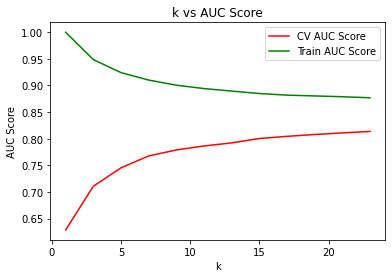

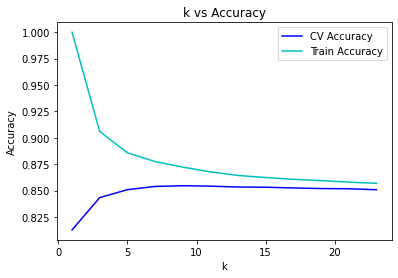

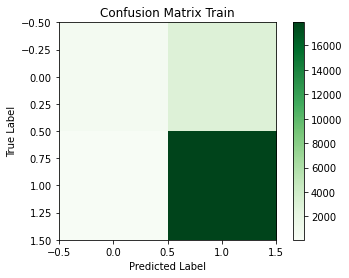

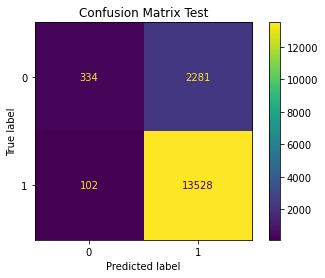

95248    1
45518    0
4590     1
7914     1
37228    1
        ..
18698    1
85558    1
34765    1
66724    0
88082    1
Name: Review, Length: 16245, dtype: int32 

[1.         0.26086957 0.95652174 ... 0.91304348 0.7826087  0.65217391] 

[1 0 1 ... 1 1 1] 

AUC Score (Test): 0.8251648245280557
Accuracy (Test): 0.8533087103724223


In [39]:
auc_score_bow_test_KNN, accuracy_bow_test_KNN = KNN_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 KNN on tf-idf

1 - AUC Score (CV): 0.6322002321204606  Accuracy (CV): 0.8180376795373997
3 - AUC Score (CV): 0.7084973562438625  Accuracy (CV): 0.8481626562208543
5 - AUC Score (CV): 0.7432615666123508  Accuracy (CV): 0.8545513896661071
7 - AUC Score (CV): 0.7652634856589742  Accuracy (CV): 0.8582354038425667
9 - AUC Score (CV): 0.7821025213495019  Accuracy (CV): 0.858468569296773
11 - AUC Score (CV): 0.7919850490800171  Accuracy (CV): 0.8570695765715352
13 - AUC Score (CV): 0.7989466040426042  Accuracy (CV): 0.85613691475471
15 - AUC Score (CV): 0.8062032083779346  Accuracy (CV): 0.8559037493005036
17 - AUC Score (CV): 0.8110122808313095  Accuracy (CV): 0.8547379220294721
19 - AUC Score (CV): 0.8159167977111539  Accuracy (CV): 0.8538985263943294
21 - AUC Score (CV): 0.8216335375275805  Accuracy (CV): 0.8538985263943294
23 - AUC Score (CV): 0.825845958143237  Accuracy (CV): 0.853478828576758
Best k-value based on AUC: 23
Best accuracy: 0.858468569296773


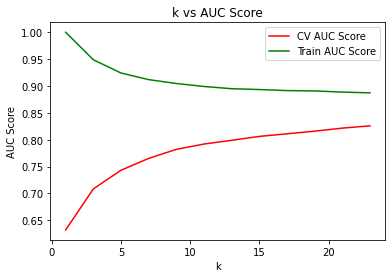

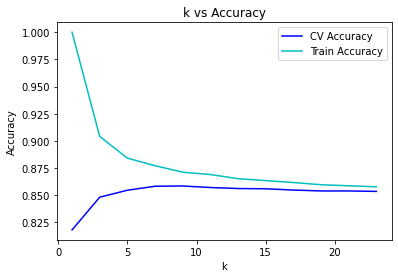

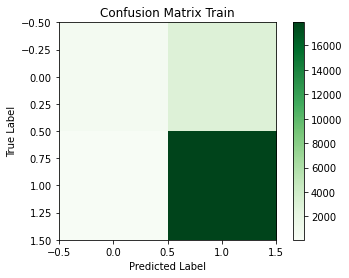

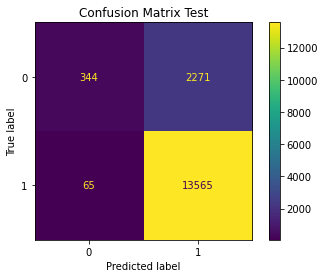

95248    1
45518    0
4590     1
7914     1
37228    1
        ..
18698    1
85558    1
34765    1
66724    0
88082    1
Name: Review, Length: 16245, dtype: int32 

[1.         0.43478261 0.91304348 ... 0.95652174 0.91304348 0.91304348] 

[1 0 1 ... 1 1 1] 

AUC Score (Test): 0.8225239005736138
Accuracy (Test): 0.8562019082794706


In [40]:
auc_score_tf_idf_test_KNN, accuracy_tf_idf_test_KNN = KNN_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 KNN on Tf-Idf word2vec

1 - AUC Score (CV): 0.6606559042520991  Accuracy (CV): 0.8212553628054468
3 - AUC Score (CV): 0.753278968485132  Accuracy (CV): 0.8521264689423615
5 - AUC Score (CV): 0.786670756392644  Accuracy (CV): 0.8602406267487409
7 - AUC Score (CV): 0.8021807970254484  Accuracy (CV): 0.8633184107442641
9 - AUC Score (CV): 0.8124970545027906  Accuracy (CV): 0.8646241372878194
11 - AUC Score (CV): 0.8203197593620302  Accuracy (CV): 0.8658365976496922
13 - AUC Score (CV): 0.8242301296210336  Accuracy (CV): 0.8656966983771684
15 - AUC Score (CV): 0.8283526812015904  Accuracy (CV): 0.8664428278306286
17 - AUC Score (CV): 0.8318567331586433  Accuracy (CV): 0.8662096623764223
19 - AUC Score (CV): 0.8347991945681452  Accuracy (CV): 0.8656500652863272
21 - AUC Score (CV): 0.8360413400644976  Accuracy (CV): 0.8654168998321209
23 - AUC Score (CV): 0.8368474018072491  Accuracy (CV): 0.8650438351053907
Best k-value based on AUC: 23
Best accuracy: 0.8664428278306286


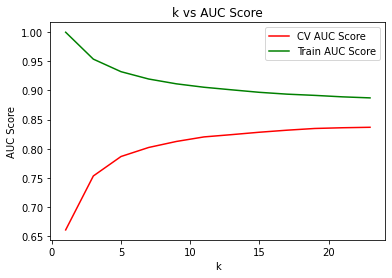

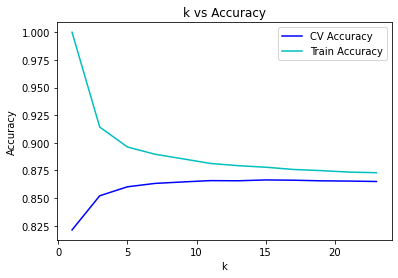

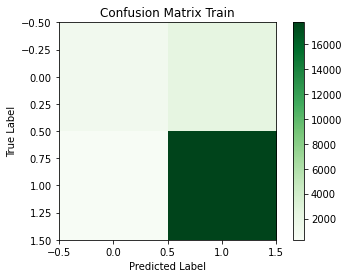

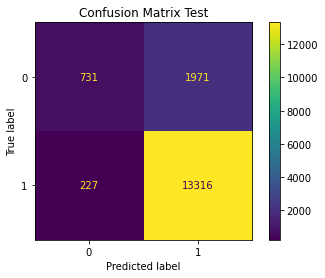

9594     0
33708    1
53266    1
57074    0
31506    1
        ..
96733    1
4610     1
7298     1
72096    1
3148     0
Name: Review, Length: 16245, dtype: int32 

[0.82608696 1.         0.91304348 ... 1.         0.73913043 0.91304348] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8422520930536084
Accuracy (Test): 0.8646968297937827


In [41]:
auc_score_word2vec_test_KNN, accuracy_bword2vec_test_KNN = KNN_train_simple_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

In [42]:
# Naive Bayes from here

 NaiveBayes on Bag of Words

AUC Score (CV): 0.8487424063239872  Accuracy (CV): 0.8380432755083007
AUC Score (Train): 0.8686272463490844  Accuracy (Train): 0.8379961411245865


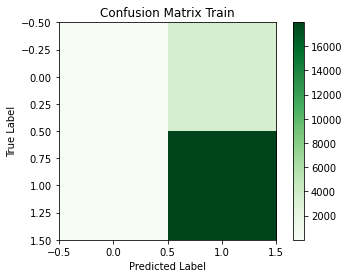

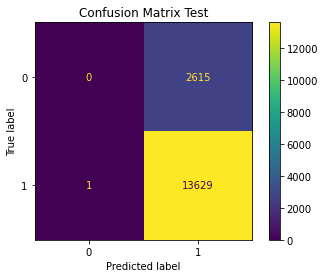

AUC Score (Test): 0.8453590030988329
Accuracy (Test): 0.8389658356417359


In [43]:
auc_score_bow_test_NB, accuracy_bow_test_NB = NaiveBayes_train_simple_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 NaiveBayes on tf-idf

AUC Score (CV): 0.798003191083539  Accuracy (CV): 0.8380432755083007
AUC Score (Train): 0.9230514875747383  Accuracy (Train): 0.8379502021315692


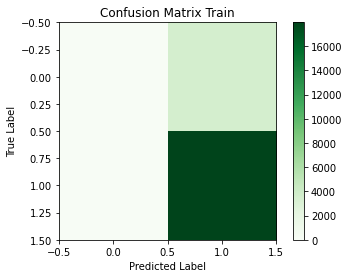

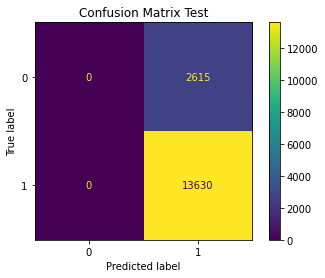

AUC Score (Test): 0.7756915419675134
Accuracy (Test): 0.8390273930440135


In [44]:
auc_score_tf_idf_test_NB, accuracy_tf_idf_test_NB = NaiveBayes_train_simple_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 NaiveBayes on Tf-Idf word2vec

In [45]:
# auc_score_tfidf_word2vec_test_NB, accuracy_tfidf_word2vec_test_NB = NaiveBayes_train_simple_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

In [46]:
# SGD Classifier from here

 SGD Classifier on Bag of Words

Best Hyperparameters: {'alpha': 1.9211659757411964e-06, 'eta0': 0.01}
AUC Score (CV): 0.940717090623161  Accuracy (CV): 0.9122831561275881
AUC Score (Train): 0.9772136038660241  Accuracy (Train): 0.9482726938625505


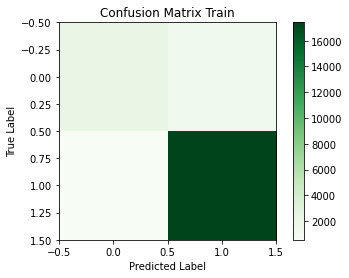

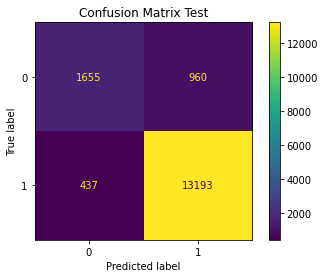

95248    1
45518    0
4590     1
7914     1
37228    1
        ..
18698    1
85558    1
34765    1
66724    0
88082    1
Name: Review, Length: 16245, dtype: int32 

[0.99946146 0.22723814 0.98790039 ... 0.99104394 0.91122581 0.96377264] 

[1 0 1 ... 1 1 1] 

AUC Score (Test): 0.9373127548751559
Accuracy (Test): 0.9140043090181594


In [47]:
auc_score_bow_test_SGDC, accuracy_bow_test_SGDC = SGDClassifier_train_random_search_cv(X_train_bow, Y_train, X_test_bow, Y_test)

 SGD Classifier on tf-idf

Best Hyperparameters: {'alpha': 1.9211659757411964e-06, 'eta0': 0.01}
AUC Score (CV): 0.9541331450229914  Accuracy (CV): 0.9191382204812535
AUC Score (Train): 0.9999998193286872  Accuracy (Train): 0.9998621830209482


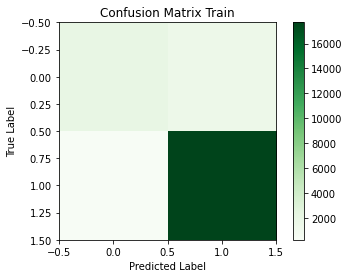

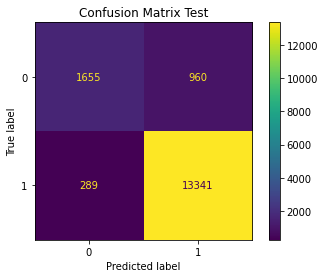

95248    1
45518    0
4590     1
7914     1
37228    1
        ..
18698    1
85558    1
34765    1
66724    0
88082    1
Name: Review, Length: 16245, dtype: int32 

[0.99407118 0.15497118 0.97802675 ... 0.98474335 0.90186535 0.96678434] 

[1 0 1 ... 1 1 1] 

AUC Score (Test): 0.9511506363900348
Accuracy (Test): 0.9231148045552477


In [48]:
auc_score_tf_idf_test_SGDC, accuracy_tf_idf_test_SGDC = SGDClassifier_train_random_search_cv(X_train_tfidf, Y_train, X_test_tfidf, Y_test)

 SGD Classifier on Tf-Idf word2vec

Best Hyperparameters: {'alpha': 8.264328927007723e-05, 'eta0': 0.2}
AUC Score (CV): 0.8927425367655278  Accuracy (CV): 0.8794068270844991
AUC Score (Train): 0.8949658241045102  Accuracy (Train): 0.8833149577361264


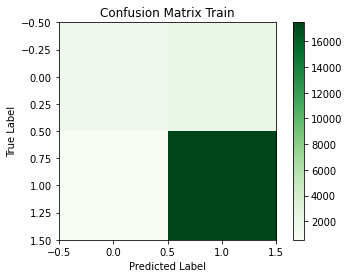

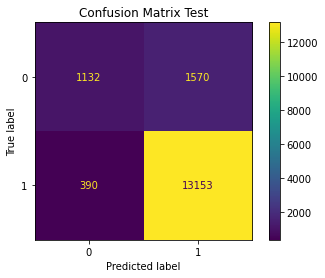

9594     0
33708    1
53266    1
57074    0
31506    1
        ..
96733    1
4610     1
7298     1
72096    1
3148     0
Name: Review, Length: 16245, dtype: int32 

[0.93297106 0.99893905 0.81637743 ... 0.98538028 0.74535641 0.90924646] 

[1 1 1 ... 1 1 1] 

AUC Score (Test): 0.8902666195832196
Accuracy (Test): 0.8793474915358572


In [49]:
auc_score_tfidf_word2vec_test_SGDC, accuracy_tfidf_word2vec_test_SGDC = SGDClassifier_train_random_search_cv(X_train_tfidf_word2vec, Y_train_tfidf_wor2vec, X_test_tfidf_word2vec, Y_test_tfidf_wor2vec)

# KNN, Naive Bayes, and SGD Completed